# Demonestic and Inbouned 

## Libraries 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

## domenstic data 

In [1011]:
# domenstic data 
## read data file

df_d = pd.read_excel('raw_data/D_data.xlsx')

## crete date column and set it as index then drop the (yeaer month) columns
df_d['Date'] = pd.to_datetime(df_d['Year'].astype(str) + ' ' + df_d['Month'])
df_d.set_index('Date', inplace=True)
df_d.drop(columns=['Year', 'Month'], inplace=True)
df_d = df_d.dropna()

## rename the column
df_d.rename(columns={'Tourists Number Overnight Visitors': 'number of visitor'}, inplace=True)

/var/folders/kb/gc9pqtqx4lz2rj1xp776bfxm0000gn/T/ipykernel_1726/2329497224.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_d['Date'] = pd.to_datetime(df_d['Year'].astype(str) + ' ' + df_d['Month'])


In [1012]:
visitor_num_d = pd.DataFrame(df_d['number of visitor'])
spend_d = pd.DataFrame(df_d['Tourists Spending'])
# spend_d

### models for VISITORS NUM

#### data split

In [1013]:
# Let's keep the last 20% of the values out for testing purposes
train_size = 0.9
visitor_num_d_index = round(train_size*visitor_num_d.shape[0])

## VISITOR DATA
visitor_num_d_train = visitor_num_d.iloc[:visitor_num_d_index]
visitor_num_d_test = visitor_num_d.iloc[visitor_num_d_index:]

#### baseline model

In [1014]:
## predict the # visitors of prevus month as the # visitors of next month
visitor_num_d_y_pred = visitor_num_d_test.shift(1).dropna()
visitor_num_d_y_true = visitor_num_d_test[1:]

visitor_num_d_base_accuracy = mean_absolute_percentage_error(visitor_num_d_y_true, visitor_num_d_y_pred)
print(f"baseline model mape for visitor_num : {visitor_num_d_base_accuracy}")

baseline model mape for visitor_num : 0.16183560329824545


#### Prophet

In [1015]:
## prepare data for prophet TRAIN 
visitor_num_d_prophet_train = visitor_num_d_train.reset_index().rename(columns={
    'Date': 'ds',
    'number of visitor': 'y'
})


## prepare data for prophet TEST 
visitor_num_d_prophet_test = visitor_num_d_test.reset_index().rename(columns={
    'Date': 'ds',
    'number of visitor': 'y'
})

In [17]:
from hijri_converter import convert
import pandas as pd

def make_saudi_holidays(start_hijri_year=1436, end_hijri_year=1445):
    eid_alfitr = []
    eid_aladha = []
    national_day = []
    founding_day = []
    riyadh_season = []
    jeddah_season = []
    mid_year_break = []
    end_year_break = []

    # عيد الفطر
    for year in range(start_hijri_year, end_hijri_year + 1):
        date = convert.Hijri(year, 10, 1).to_gregorian()
        eid_alfitr.append({'holiday': 'eid_alfitr', 'ds': pd.to_datetime(date.isoformat()),
                           'lower_window': 0, 'upper_window': 3})

    # عيد الأضحى
    for year in range(start_hijri_year, end_hijri_year + 1):
        date = convert.Hijri(year, 12, 10).to_gregorian()
        eid_aladha.append({'holiday': 'eid_aladha', 'ds': pd.to_datetime(date.isoformat()),
                           'lower_window': 0, 'upper_window': 3})

    # اليوم الوطني
    for year in range(2015, 2024):
        national_day.append({'holiday': 'national_day', 'ds': pd.to_datetime(f'{year}-09-23'),
                             'lower_window': 0, 'upper_window': 1})

    # يوم التأسيس
    for year in range(2022, 2024):
        founding_day.append({'holiday': 'founding_day', 'ds': pd.to_datetime(f'{year}-02-22'),
                             'lower_window': 0, 'upper_window': 1})

    # موسم الرياض
    for year in range(2019, 2024):
        riyadh_season.append({'holiday': 'riyadh_season_start', 'ds': pd.to_datetime(f'{year}-10-01'),
                              'lower_window': 0, 'upper_window': 45})

    # موسم جدة
    for year in range(2019, 2024):
        jeddah_season.append({'holiday': 'jeddah_season_start', 'ds': pd.to_datetime(f'{year}-06-01'),
                              'lower_window': 0, 'upper_window': 45})

    # إجازة منتصف العام (يناير تقريبًا)
    for year in range(2015, 2024):
        mid_year_break.append({'holiday': 'mid_year_break', 'ds': pd.to_datetime(f'{year}-01-01'),
                               'lower_window': 0, 'upper_window': 15})

    # إجازة نهاية العام الدراسي (يونيو تقريبًا)
    for year in range(2015, 2024):
        end_year_break.append({'holiday': 'end_year_break', 'ds': pd.to_datetime(f'{year}-06-15'),
                               'lower_window': 0, 'upper_window': 20})

    # دمج جميع الإجازات
    holidays_df = pd.DataFrame(
        eid_alfitr + eid_aladha + national_day + founding_day + riyadh_season + jeddah_season + mid_year_break + end_year_break
    )
    return holidays_df

saudi_holidays = make_saudi_holidays()

In [18]:
saudi_holidays = make_saudi_holidays()

In [1018]:
# Fit the model
#prophet = Prophet()
prophet = Prophet(
 seasonality_mode='multiplicative',
    yearly_seasonality=True,
    holidays=saudi_holidays,
    holidays_prior_scale=3,
    changepoint_prior_scale=0.05,
    changepoint_range=0.85    
)
prophet.fit(visitor_num_d_prophet_train)

# Prepare the future DataFrame (dates) for prediction
future = visitor_num_d_prophet_test[['ds']]  # Just the dates from your test set
preds = prophet.predict(future)  # Get predictions

# Calculate accuracy using MAPE
y_true = visitor_num_d_prophet_test['y'].values
y_pred = preds['yhat'].values



visitor_num_d_prophet_accuracy = mean_absolute_percentage_error(y_true, y_pred)
print(f"Prophet MAPE for visitor_num: {visitor_num_d_prophet_accuracy:.2%}")

visitor_num_d_prophet_accuracy = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE for visitors: {visitor_num_d_prophet_accuracy:.2f}")

## WITH DIFFERENT SPLIT SIZE: 
## lower is better
# 0.9 >> MAPE: 8.41%


#-------------------------------------------------
# without pramete change (Prophet MAPE for visitor_num: 8.47%)
# after firist Prameter ---> 8.36 %
# after holday ---->7.84%
#Prophet MAPE for visitor_num: 7.79%
#RMSE for visitors: 684.80


10:56:38 - cmdstanpy - INFO - Chain [1] start processing
10:56:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAPE for visitor_num: 7.79%
RMSE for visitors: 684.80


delete or not??????

In [1019]:
# Fit the model
prophet = Prophet()
prophet.fit(visitor_num_d_prophet_train)

# Prepare the future DataFrame (dates) for prediction
Test_size = visitor_num_d_prophet_test.shape[0]
future = prophet.make_future_dataframe(periods=Test_size, freq='m')
forecast = prophet.predict(future)
predictions = forecast.tail(Test_size)

error = mean_absolute_percentage_error(visitor_num_d_prophet_test['y'], predictions['yhat'])   
print('error is:', error)

10:56:38 - cmdstanpy - INFO - Chain [1] start processing
10:56:38 - cmdstanpy - INFO - Chain [1] done processing


error is: 0.0761304481354858


/Users/mahabunaydir/.pyenv/versions/3.10.6/envs/saudi_arabia_tourism_forecast/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


#### Charts

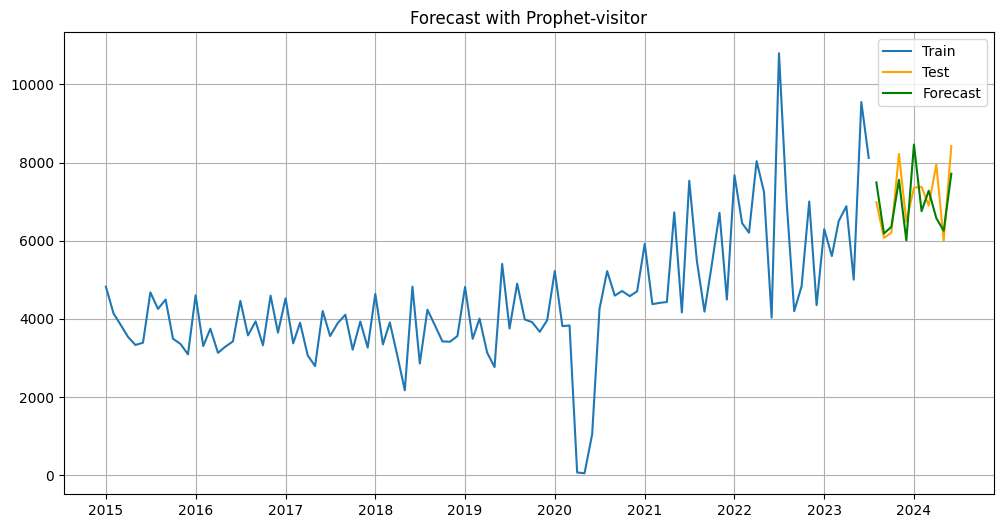

In [1020]:
# Extract pandas series for plotting

visitor_num_d_prophet_train = visitor_num_d_prophet_train.set_index('ds')
visitor_num_d_prophet_test = visitor_num_d_prophet_test.set_index('ds')

train = visitor_num_d_prophet_train['y']
test = visitor_num_d_prophet_test['y']
forecast = pd.Series(y_pred, index=test.index)


plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(forecast.index, forecast, label='Forecast', color='green')
plt.title('Forecast with Prophet-visitor')
plt.legend()
plt.grid(True)
plt.show()


In [1021]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"MAPE: {mape * 100:.2f}%")


MAPE: 7.79%


### models for SPENDS

#### data split 

In [1022]:
## SPENDS DATA
train_size = 0.9
spends_d_index = round(train_size*spend_d.shape[0])

spends_d_train = spend_d.iloc[:spends_d_index]
spends_d_test = spend_d.iloc[spends_d_index:]

#### baseline model

In [1023]:
## predict the # visitors of prevus month as the # visitors of next month
spends_d_y_pred = spends_d_test.shift(1).dropna()
spends_d_y_true = spends_d_test[1:]
spends_d_base_accuracy = mean_absolute_percentage_error(spends_d_y_true, spends_d_y_pred)
print(f"baseline model mape for spends: {spends_d_base_accuracy}")

baseline model mape for spends: 0.12697341353249217


#### prophet

In [1024]:
## prepare data for prophet TRAIN 
spends_d_prophet_train = spends_d_train.reset_index().rename(columns={
    'Date': 'ds',
    'Tourists Spending': 'y'
})


## prepare data for prophet TEST 
spends_d_prophet_test = spends_d_test.reset_index().rename(columns={
    'Date': 'ds',
    'Tourists Spending': 'y'
})



In [1025]:
# Fit the model
#prophet = Prophet()

prophet = Prophet()

prophet.fit(spends_d_prophet_train)

# Prepare the future DataFrame (dates) for prediction
future = spends_d_prophet_test[['ds']]  # Just the dates from your test set
preds = prophet.predict(future)  # Get predictions

# Calculate accuracy using MAPE
y_true = spends_d_prophet_test['y'].values
y_pred = preds['yhat'].values




spends_d_prophet_accuracy = mean_absolute_percentage_error(y_true, y_pred)
print(f"Prophet MAPE for spends: {spends_d_prophet_accuracy:.2%}")

spends_d_prophet_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE for spends: {spends_d_prophet_rmse:.2f}")


## WITH DIFFERENT SPLIT SIZE: 
# 0.9 >> MAPE: 10.97%
# without Prameter :
#MAPE for spends: 10.64%
#RMSE for spends: 1444.94

10:56:38 - cmdstanpy - INFO - Chain [1] start processing
10:56:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAPE for spends: 10.64%
RMSE for spends: 1444.94


delete or not??????

In [1026]:

# Fit the model
prophet = Prophet()
prophet.fit(spends_d_prophet_test)

# Prepare the future DataFrame (dates) for prediction
Test_size = spends_d_prophet_test.shape[0]
future = prophet.make_future_dataframe(periods=Test_size, freq='m')
forecast = prophet.predict(future)
predictions = forecast.tail(Test_size)

error = mean_absolute_percentage_error(spends_d_prophet_test['y'], predictions['yhat'])   
print('error is:', error)

10:56:38 - cmdstanpy - INFO - Chain [1] start processing
10:56:38 - cmdstanpy - INFO - Chain [1] done processing
/Users/mahabunaydir/.pyenv/versions/3.10.6/envs/saudi_arabia_tourism_forecast/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


error is: 0.2571648146604408


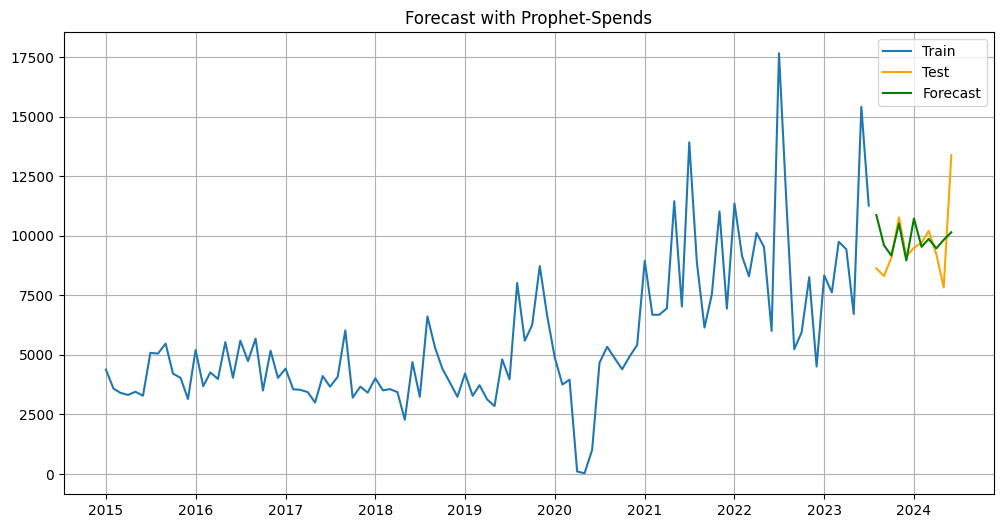

In [1027]:
spends_d_prophet_train = spends_d_prophet_train.set_index('ds')
spends_d_prophet_test = spends_d_prophet_test.set_index('ds')

train = spends_d_prophet_train['y']
test = spends_d_prophet_test['y']
forecast = pd.Series(y_pred, index=test.index)


plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(forecast.index, forecast, label='Forecast', color='green')
plt.title('Forecast with Prophet-Spends')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_10302/1001330796.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_i['Date'] = pd.to_datetime(df_i['Year'].astype(str) + ' ' + df_i['Month'])


,number of visitor,Overnight Stay,Tourists Spending,Average Length of Stay,Avergae Spending per Trip,Average Spending per Night,Religious,Leisure,Business,Visiting Friends and Relatives,...,Private,Other,Total,ACCOMMODATION SPEND in MILLION SAR,ENTERTAINMENT SPEND in MILLION SAR,FOOD SPENDS in MILLION SAR,LOCAL TRANSPORT SPENDS in MILLION SAR,SHOPPING SPEND in MILLION SAR,OTHER SPEND in MILLION SAR,TOTAL SPENDS in MILLION SAR
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,2247.108716,22786.205665,8942.891117,10.140233,3979.732289,392.469516,1188.680957,269.830450,21.932781,476.286010,...,407.659934,59.423627,2247.108716,4178.000000,402.000000,906.000000,1009.000000,1592.000000,856.000000,8943.000000
2015-02-01,1704.247343,18623.357319,8072.564954,10.927614,4736.733190,433.464537,1102.405861,174.080482,40.238499,242.360359,...,180.663330,32.145750,1704.247343,3755.000000,281.000000,946.000000,1014.000000,1433.000000,643.000000,8073.000000
2015-03-01,1533.266267,14684.551872,6690.145796,9.577301,4363.329410,455.590736,978.101284,138.824224,35.979820,208.495550,...,188.291173,63.788260,1533.266267,3134.000000,195.000000,865.000000,743.000000,1172.000000,581.000000,6690.000000
2015-04-01,1574.023954,16834.418142,6174.227602,10.695147,3922.575375,366.762162,911.930406,93.753138,11.399367,205.232784,...,378.944595,37.113298,1574.023954,3183.000000,144.000000,622.000000,675.000000,1174.000000,377.000000,6174.000000
2015-05-01,1396.368298,12500.283679,5685.580226,8.951996,4071.690997,454.836096,589.122219,111.260754,179.006869,253.934684,...,334.912092,31.924759,1396.368298,2391.000000,125.000000,813.000000,549.000000,1421.000000,386.000000,5686.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-01,3108.638000,46882.170000,16241.064014,15.081257,5224.500000,346.420000,1376.117000,178.691000,738.194000,214.930000,...,59.306000,455.994000,3108.638000,5739.267758,655.542935,2176.370041,2535.067334,2526.143647,2608.672298,16241.064014
2024-03-01,3157.710000,57690.978000,18975.707303,18.269878,6009.330000,328.920000,1526.776000,161.054000,728.066000,146.725000,...,42.995000,538.480000,3157.710000,6845.947217,738.586055,2496.172800,2953.428735,2831.922531,3109.649968,18975.707303
2024-04-01,2051.354000,33134.167000,10609.632757,16.152340,5172.010000,320.200000,669.696000,120.669000,685.348000,117.133000,...,30.752000,419.175000,2051.354000,3352.574124,386.140162,1672.743388,1786.256664,1949.819698,1462.098717,10609.632757


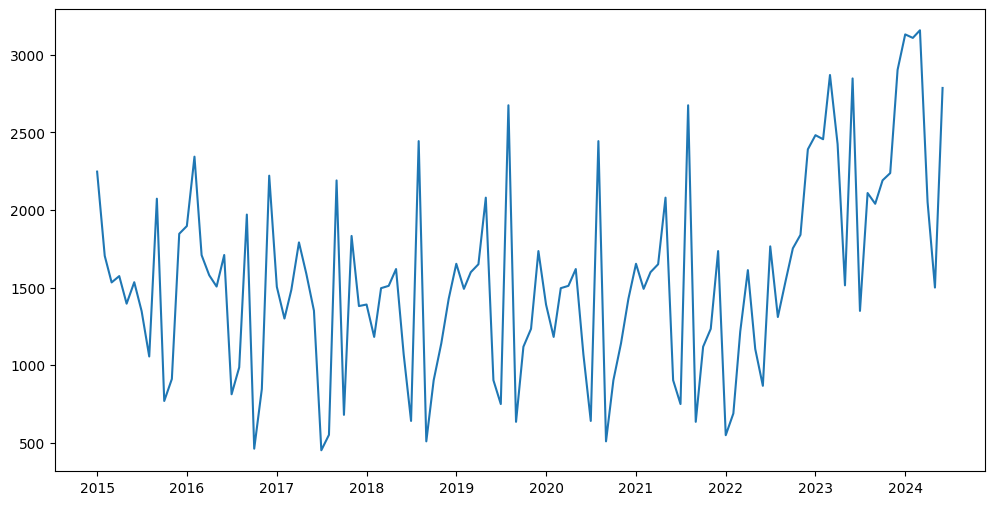

In [3]:
# inbound data 
## read data file
df_i = pd.read_excel('raw_data/I_data.xlsx')

## crete date column and set it as index then drop the (yeaer month) columns
df_i['Date'] = pd.to_datetime(df_i['Year'].astype(str) + ' ' + df_i['Month'])
df_i.set_index('Date', inplace=True)
df_i.drop(columns=['Year', 'Month'], inplace=True)
df_i = df_i.dropna()
# Filter out the 2020 to 2022 period
# df_i = df_i.loc[(df_i.index < '2020-01-01') | (df_i.index >= '2022-12-31')]
# df_i = df_i.loc[(df_i.index >= '2022-12-31')]

## rename the column
df_i.rename(columns={'Tourists Number Overnight Visitors': 'number of visitor'}, inplace=True)
df_i.head()


df_i_replaced =df_i.copy()

df_i_replaced.loc['2020-01-01':'2021-12-31','number of visitor']  = list(df_i_replaced.loc['2018-01-01':'2019-12-31','number of visitor']) 

plt.figure(figsize=(12, 6))
plt.plot(df_i_replaced.index, df_i_replaced['number of visitor'],label = 'replaced')
df_i_replaced

In [6]:
visitor_num_i = pd.DataFrame(df_i_replaced['number of visitor'])
spend_i = pd.DataFrame(df_i_replaced['Tourists Spending'])
# spend_d

In [7]:
## SPENDS DATA
train_size = 0.9
spends_i_index = round(train_size*spend_i.shape[0])

spends_i_train = spend_d.iloc[:spends_i_index]
spends_i_test = spend_d.iloc[spends_i_index:]

In [8]:
## prepare data for prophet TRAIN 
spends_i_prophet_train = spends_i_train.reset_index().rename(columns={
    'Date': 'ds',
    'Tourists Spending': 'y'
})


## prepare data for prophet TEST 
spends_i_prophet_test = spends_i_test.reset_index().rename(columns={
    'Date': 'ds',
    'Tourists Spending': 'y'
})


In [9]:
# Fit the model
#prophet = Prophet()

prophet = Prophet()

prophet.fit(spends_i_prophet_train)

# Prepare the future DataFrame (dates) for prediction
future = spends_i_prophet_test[['ds']]  # Just the dates from your test set
preds = prophet.predict(future)  # Get predictions

# Calculate accuracy using MAPE
y_true = spends_i_prophet_test['y'].values
y_pred = preds['yhat'].values




spends_i_prophet_accuracy = mean_absolute_percentage_error(y_true, y_pred)
print(f"Prophet MAPE for spends: {spends_i_prophet_accuracy:.2%}")

spends_i_prophet_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE for spends: {spends_i_prophet_rmse:.2f}")


## WITH DIFFERENT SPLIT SIZE: 
# 0.9 >> MAPE: 10.97%
# without Prameter :
#MAPE for spends: 10.64%
#RMSE for spends: 1444.94

14:37:19 - cmdstanpy - INFO - Chain [1] start processing
14:37:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAPE for spends: 46.96%
RMSE for spends: 8826.44


In [11]:

# Fit the model
prophet = Prophet()

# Prepare the future DataFrame (dates) for prediction
Test_size = spends_i_prophet_test.shape[0]
future = prophet.make_future_dataframe(periods=Test_size, freq='m')
forecast = prophet.predict(future)
predictions = forecast.tail(Test_size)

error = mean_absolute_percentage_error(spends_i_prophet_test['y'], predictions['yhat'])   
print('error is:', error)

14:37:44 - cmdstanpy - INFO - Chain [1] start processing
14:37:44 - cmdstanpy - INFO - Chain [1] done processing


error is: 1.416021364220852


/home/sukainah/.pyenv/versions/3.10.6/envs/saudi_arabia_tourism_forecast/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


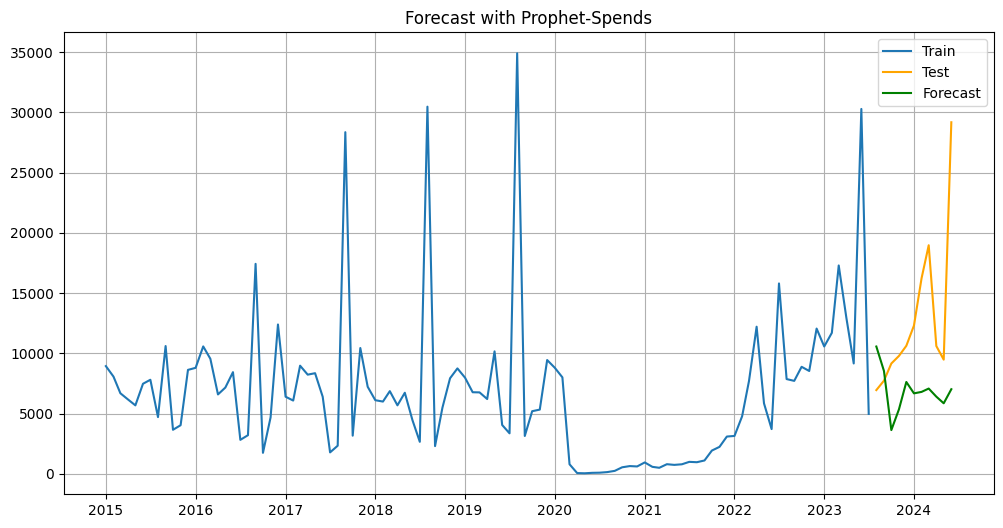

In [12]:
spends_i_prophet_train = spends_i_prophet_train.set_index('ds')
spends_i_prophet_test = spends_i_prophet_test.set_index('ds')

train = spends_i_prophet_train['y']
test = spends_i_prophet_test['y']
forecast = pd.Series(y_pred, index=test.index)


plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(forecast.index, forecast, label='Forecast', color='green')
plt.title('Forecast with Prophet-Spends')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Let's keep the last 20% of the values out for testing purposes
train_size = 0.9
visitor_num_i_index = round(train_size*visitor_num_i.shape[0])

## VISITOR DATA
visitor_num_i_train = visitor_num_i.iloc[:visitor_num_i_index]
visitor_num_i_test = visitor_num_i.iloc[visitor_num_i_index:]

In [23]:
## predict the # visitors of prevus month as the # visitors of next month
visitor_num_i_y_pred = visitor_num_i_test.shift(1).dropna()
visitor_num_i_y_true = visitor_num_i_test[1:]

visitor_num_i_base_accuracy = mean_absolute_percentage_error(visitor_num_i_y_true, visitor_num_i_y_pred)
print(f"baseline model mape for visitor_num : {visitor_num_i_base_accuracy}")

baseline model mape for visitor_num : 0.18169292402492024


In [24]:
## prepare data for prophet TRAIN 
visitor_num_i_prophet_train = visitor_num_i_train.reset_index().rename(columns={
    'Date': 'ds',
    'number of visitor': 'y'
})


## prepare data for prophet TEST 
visitor_num_i_prophet_test = visitor_num_i_test.reset_index().rename(columns={
    'Date': 'ds',
    'number of visitor': 'y'
})

In [25]:
# Fit the model
#prophet = Prophet()
prophet = Prophet(
 seasonality_mode='multiplicative',
    yearly_seasonality=True,
    holidays=saudi_holidays,
    holidays_prior_scale=3,
    changepoint_prior_scale=0.05,
    changepoint_range=0.85    
)
prophet.fit(visitor_num_i_prophet_train)

# Prepare the future DataFrame (dates) for prediction
future = visitor_num_i_prophet_test[['ds']]  # Just the dates from your test set
preds = prophet.predict(future)  # Get predictions

# Calculate accuracy using MAPE
y_true = visitor_num_i_prophet_test['y'].values
y_pred = preds['yhat'].values



visitor_num_i_prophet_accuracy = mean_absolute_percentage_error(y_true, y_pred)
print(f"Prophet MAPE for visitor_num: {visitor_num_i_prophet_accuracy:.2%}")

visitor_num_i_prophet_accuracy = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE for visitors: {visitor_num_i_prophet_accuracy:.2f}")

## WITH DIFFERENT SPLIT SIZE: 
## lower is better
# 0.9 >> MAPE: 8.41%


#-------------------------------------------------
# without pramete change (Prophet MAPE for visitor_num: 8.47%)
# after firist Prameter ---> 8.36 %
# after holday ---->7.84%
#Prophet MAPE for visitor_num: 7.79%
#RMSE for visitors: 684.80


14:45:10 - cmdstanpy - INFO - Chain [1] start processing
14:45:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAPE for visitor_num: 33.71%
RMSE for visitors: 998.72


In [26]:
# Fit the model
prophet = Prophet()
prophet.fit(visitor_num_i_prophet_train)

# Prepare the future DataFrame (dates) for prediction
Test_size = visitor_num_i_prophet_test.shape[0]
future = prophet.make_future_dataframe(periods=Test_size, freq='m')
forecast = prophet.predict(future)
predictions = forecast.tail(Test_size)

error = mean_absolute_percentage_error(visitor_num_i_prophet_test['y'], predictions['yhat'])   
print('error is:', error)

14:45:10 - cmdstanpy - INFO - Chain [1] start processing
14:45:10 - cmdstanpy - INFO - Chain [1] done processing


error is: 0.33485434619782994


/home/sukainah/.pyenv/versions/3.10.6/envs/saudi_arabia_tourism_forecast/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


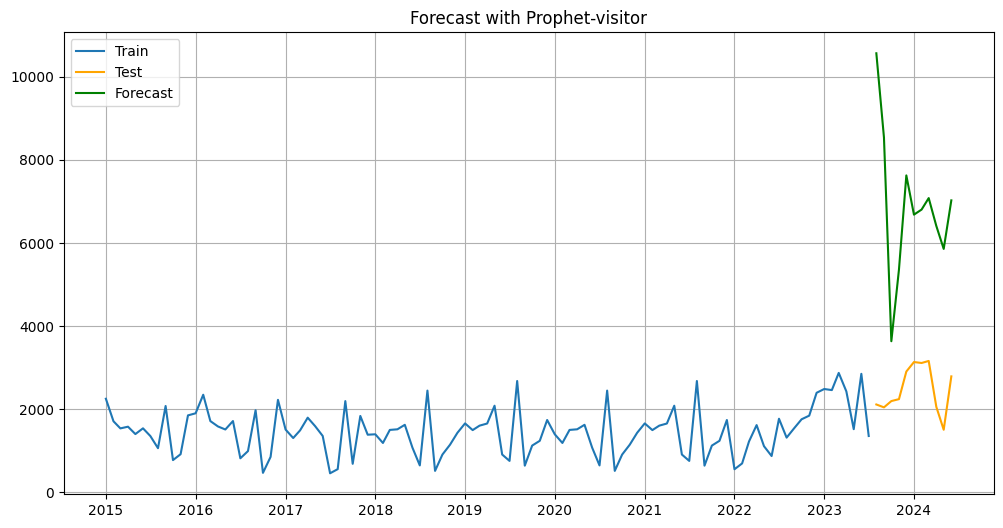

In [20]:
# Extract pandas series for plotting

visitor_num_i_prophet_train = visitor_num_i_prophet_train.set_index('ds')
visitor_num_i_prophet_test = visitor_num_i_prophet_test.set_index('ds')

train = visitor_num_i_prophet_train['y']
test = visitor_num_i_prophet_test['y']
forecast = pd.Series(y_pred, index=test.index)


plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(forecast.index, forecast, label='Forecast', color='green')
plt.title('Forecast with Prophet-visitor')
plt.legend()
plt.grid(True)
plt.show()
